In [1]:
import becquerel as bq
from becquerel import Spectrum
from becquerel.tools.isotope import Isotope
from becquerel.tools.isotope_qty import IsotopeQuantity, NeutronIrradiation
import datetime
import numpy as np
import scipy.integrate as integrate
import math as m
import importlib
import pandas as pd
import sys
import os
import csv
import matplotlib.pyplot as plt
import re
sys.path.insert(0,r'C:\Users\ahanks\DoseNet\radwatch-analysis')

In [2]:
import PF
import naa_isotope_analyzer as naa
import analysis_methods as am
import ROI
importlib.reload(PF)
importlib.reload(naa)
importlib.reload(am)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\ahanks\\DoseNet\\radwatch-analysis\\ROI.py'>

In [3]:
def get_isotopes(energies):
    hl_cut = 600 #in becq.fetch decay radiation
    br_cut =4.0
    df = naa.naa_isotope_analyzer(energies,hl_cut,br_cut,deltae=5.0)
    
    return df

In [39]:
sample_masses = [1.0,1.1,1.0,1.1,1.0,1.0,1.1,1.0,0.9,1.0]
sample_fish = ["Petrale Sole 1","Halibut","Tilapia","Rockfish","Rock Cod","Catfish","Petrale Sole 2",
               "Wild King Salmon","Swordfish","Oysters"]
sample_mass_unc = 0.1

In [7]:
sample_index = 1

In [5]:
#use the ecal and bgspec from google drive
#implement choosing between relevant ecal and bg for diff sample groups
path = r"C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019"
e_cal = np.loadtxt(path + r"\NAA\11-19-2019-Calibration.Ent")
bgspec =  Spectrum.from_file(path + r"\NAA\Background_Spectrum_12_20_19.Spe")

SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\NAA\Background_Spectrum_12_20_19.Spe


In [11]:
#specs for testing
sample_name = r"\NAA\ucb19"
if sample_index < 9:
    sample_name = sample_name + "0"
sample_name = sample_name + str(sample_index+1)
print(sample_name)
spec_30 = Spectrum.from_file(path+sample_name + "-30min.Spe")
spec_03 = Spectrum.from_file(path+sample_name + "-3hr.Spe")
spec_24 = Spectrum.from_file(path+sample_name+"-24hr.Spe")

\NAA\ucb1902
SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\NAA\ucb1902-30min.Spe
SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\NAA\ucb1902-3hr.Spe
SpeFile: Reading file C:\Users\ahanks\Google Drive\RadWatch\Gamma\Gamma Spectra\Fish Samples 2019\NAA\ucb1902-24hr.Spe


In [12]:
specs= [spec_30,spec_03,spec_24]
cal_specs = []
for i in range(len(specs)):
    specs[i].calibrate_like(bgspec)
    cal_specs.append(specs[i])

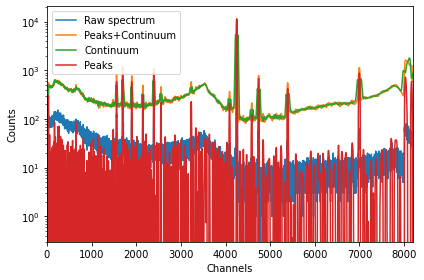

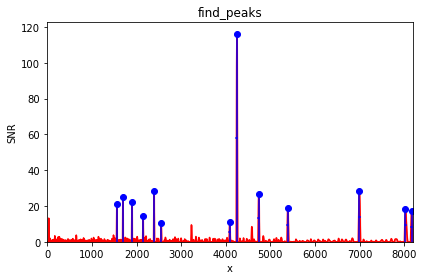

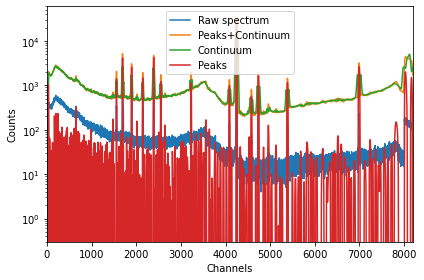

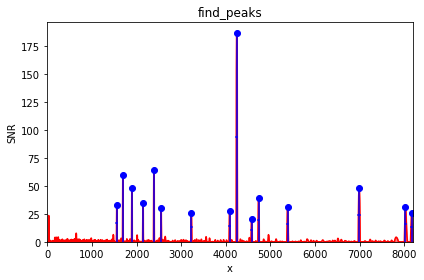

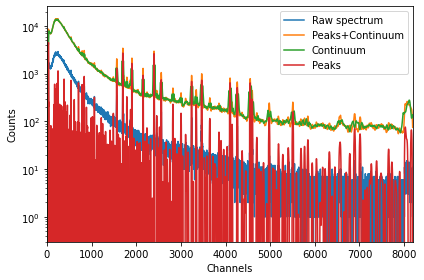

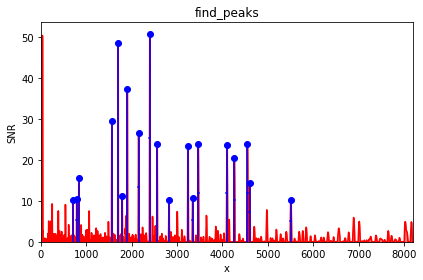

In [13]:
energies = []
for i in range(len(cal_specs)):
    energies.append(am.get_energies(cal_specs[i])) #peak finding method, bq.peakfinder


In [16]:
print(energies)

[array([ 508,  551,  616,  695,  772,  824, 1311, 1362, 1518, 1724, 2233]), array([ 507,  550,  615,  694,  772,  823, 1038, 1310, 1361, 1467, 1517,
       1723, 2232]), array([ 237,  263,  278,  509,  553,  581,  617,  696,  774,  826,  909,
       1042, 1075, 1113, 1315, 1366, 1458])]


In [14]:
energy_shift = 3

In [15]:
iso_dfs =[]
#isotope analyzer improvement
for e in energies:
    e = e + energy_shift
    iso_dfs.append(get_isotopes(e))

Backround isotopes [[], [], [], [], [], [], [], [], ['BI214'], []]
Possible isotopes [['GE77', 'AS76', 'BR82', 'IN114', 'OS193'], ['ZN71', 'ZN71', 'BR82', 'AG110', 'BA131', 'W187', 'W187'], ['BR82', 'ZR97', 'NB94'], ['GE77', 'BR82', 'MO99', 'EU152', 'HO166'], ['BR82', 'KR79', 'HO166'], ['BR82'], ['NA24', 'GE77', 'CD117', 'SB124', 'CS134'], ['K42'], [], []]
Possible isotope br [[16.8+/-1.0, 45.0, 71.7+/-1.0, 4.4+/-0.6, 1.308+/-0.02], [55.8+/-2.2, 55.8+/-2.2, 43.7+/-0.6, 2.73+/-0.08, 1.474+/-0.016, 7.57+/-0.12, 1.314+/-0.021], [28.4+/-0.4, 1.01+/-0.05, 99.814], [1.07+/-0.06, 83.6+/-1.2, 4.31+/-0.08, 12.93+/-0.08, 3.0+/-0.07], [24.2+/-0.3, 1.26+/-0.07, 9.43+/-0.22], [26.9+/-0.4], [99.9936+/-0.0015, 3.19+/-0.11, 1.65+/-0.11, 2.624+/-0.014, 3.017+/-0.008], [18.08], [], []]
Cut isotopes  [['GE77', 'AS76', 'BR82', 'IN114'], ['ZN71', 'ZN71', 'BR82', 'W187'], ['BR82', 'NB94'], ['BR82', 'MO99', 'EU152'], ['BR82', 'HO166'], ['BR82'], ['NA24'], ['K42'], [], []]
Unidentified SE associated with  223

Only found [240, 777] for isotope TE131 with [452.323+/-0.002 200.63+/-0.02 240.93+/-0.01 334.27+/-0.01 773.67+/-0.03
 782.49+/-0.04 793.75+/-0.03 822.78+/-0.04 852.21+/-0.03 1125.46+/-0.04
 1206.6+/-0.04] expected peaks.
Only found [240, 777] for isotope EU152 with [841.63+/-0.04 963.38+/-0.04 244.6974+/-0.0008 344.2785+/-0.0012
 778.9045+/-0.0024 964.057+/-0.005 1085.837+/-0.01 1112.076+/-0.003
 1408.013+/-0.003] expected peaks.
Only found [281] for isotope PA231 with [] expected peaks.
Only found [281, 829] for isotope HO166 with [280.464+/-0.002 410.949+/-0.007 529.807+/-0.011 570.976+/-0.018
 670.516+/-0.014 711.681+/-0.006 752.313+/-0.012 810.293+/-0.01
 830.585+/-0.009] expected peaks.
Only found [266, 912] for isotope AC228 with [338.32+/-0.003 911.204+/-0.004 968.971+/-0.017] expected peaks.
Only found [912] for isotope SN125 with [1067.1+/-0.05] expected peaks.
Only found [240] for isotope TH227 with [235.96+/-0.02 256.23+/-0.02] expected peaks.
Only found [281] for isotope T

In [17]:
print(energies)
iso_dfs[2]

[array([ 508,  551,  616,  695,  772,  824, 1311, 1362, 1518, 1724, 2233]), array([ 507,  550,  615,  694,  772,  823, 1038, 1310, 1361, 1467, 1517,
       1723, 2232]), array([ 237,  263,  278,  509,  553,  581,  617,  696,  774,  826,  909,
       1042, 1075, 1113, 1315, 1366, 1458])]


,isotopes,energies,branching_ratios
0,K40,[1461],[10.66]
1,XE125,[240],[30.0]
2,BA135,[266],[16.0]
3,RA223,[266],[0.137]
4,YB177,[1078],[5.08]
5,ZN65,[1116],[50.04]
6,RB86,[1078],[8.64]
7,NA24,[1369],[99.9936]
8,PB212,[240],[0.4334]


In [18]:
eff_func = am.Efficiency()
eff_func.set_parameters()

Loaded fit parameters 0-4: [-0.00530667  0.04316717 -0.01324963 -0.95566839 -4.73673214]
Loaded input energies: []
Loaded energy uncertainties: [0.03200221 0.03639874 0.03102208 0.00876822]


In [19]:
counts = []

uncertainties =[]

icounts = []
iuncertainties = []
#uses PF.PF 
for i in range(len(cal_specs)):
    icounts, iuncertainties = am.get_counts(cal_specs[i],bgspec,energies[i])
    counts.append(icounts)
    uncertainties.append(np.sqrt(icounts))

c:\users\ahanks\becquerel\becquerel\core\spectrum.py:726: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)


roi = ROI.ROI(cal_specs[0], bgspec, energies[0], sub_type = 0)
delta_e0 = 5
window0 = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(delta_e0,window0)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result0,roi_uncer0 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result0)
print('uncertainties:',roi_uncer0)

In [20]:
print(energies[0])
print(counts[0])
print(uncertainties[0])# the uncertainties are all over the place or equal to the real value
print(energies[1])
print(counts[1])
print(uncertainties[1])# the uncertainties are all over the place or equal to the real value


[ 508  551  616  695  772  824 1311 1362 1518 1724 2233]
[ 1077.73846029  1378.27746254   847.11489597   430.77501866
  1291.38628441   364.43262393   314.20547174 16086.51103348
  1009.23654814   613.94141931  1413.16313463]
[ 32.82892719  37.12515943  29.10523829  20.7551203   35.93586348
  19.09011849  17.72584192 126.83261029  31.76848357  24.7778413
  37.59206212]
[ 507  550  615  694  772  823 1038 1310 1361 1467 1517 1723 2232]
[ 2242.32329984  5665.01664817  3179.66806442  1841.60030985
  5207.81717782  1461.5051506   1364.76593854  1157.01968734
 37794.73904901   694.38066945  1913.27409163  1378.44304802
  2956.35857141]
[ 47.35317624  75.26630487  56.38854551  42.91387083  72.16520753
  38.22963707  36.94273864  34.0149921  194.40869078  26.35110376
  43.74098869  37.12738946  54.37240634]


In [21]:
ec = np.array([[ene, counts[i]/eff_func.get_eff(ene),uncertainties[i]/eff_func.get_eff(ene)] for (i, ene) in enumerate(energies)])

C:\Users\ahanks\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [22]:
print("These are for spectrum 1")
print("the energies are",ec[0,0])
print("the true counts are",ec[0,1])
print("the unc on the true counts are",ec[0,2])

These are for spectrum 1
the energies are [ 508  551  616  695  772  824 1311 1362 1518 1724 2233]
the true counts are [  48149.88656257   65567.45293943   44084.58140195   24808.07515711
   81476.1133917    24362.05880518   32320.66035053 1715975.84451268
  119404.77103647   82042.35354709  241589.90337248]
the unc on the true counts are [ 1466.69083298  1766.11909417  1514.6614146   1195.27493932
  2267.26466239  1276.16069114  1823.36390555 13529.45303706
  3758.59208971  3311.11788818  6426.62013551]


In [23]:
print(ec[1][0])
print(iso_dfs[1].energies[0])

[ 507  550  615  694  772  823 1038 1310 1361 1467 1517 1723 2232]
[553, 618, 697, 775, 826, 1041, 1313, 1470]


In [24]:
spectra = 0
for s in range(3):
    iso_dfs[s]['counts'] = "0"
    iso_dfs[s]['count_unc'] = "0"

    for j, e in enumerate(iso_dfs[s]['energies']):
        iso_dfs[s]['counts'][j] = np.zeros(len(e))
        iso_dfs[s]['count_unc'][j] = np.zeros(len(e))

    for i, det_ene in enumerate(ec[s][0]):
        for j, em_enes in enumerate(iso_dfs[s]['energies']):
            for k, in_ene in enumerate(em_enes):
                if (det_ene+energy_shift) == in_ene:
                    iso_dfs[s]['counts'][j][k] = round(ec[s][1][i])
                    iso_dfs[s]['count_unc'][j][k] = round(ec[s][2][i])

In [25]:
for i,df in enumerate(iso_dfs):
    df['cps'] = df['counts']/cal_specs[i].livetime
    df['cps_unc'] = df['count_unc']/cal_specs[i].livetime
    df = df.drop('counts',1)
    iso_dfs[i] = df.drop('count_unc',1)
iso_dfs[0]

,isotopes,energies,branching_ratios,cps,cps_unc
0,NA24,[1365],[99.9936],[953.32],[7.516111111111111]
1,K42,[1521],[18.08],[66.33611111111111],[2.0883333333333334]


In [26]:
iso_dfs[1]

,isotopes,energies,branching_ratios,cps,cps_unc
0,BR82,"[553, 618, 697, 775, 826, 1041, 1313, 1470]","[71.7, 43.7, 28.4, 83.6, 24.2, 27.6, 26.9, 16.39]","[24.917685185185185, 15.301111111111112, 9.807...","[0.33101851851851855, 0.2713888888888889, 0.22..."
1,NA24,[1364],[99.9936],[373.03777777777776],[1.9187962962962963]
2,K42,[1520],[18.08],[20.94638888888889],[0.47888888888888886]


In [ ]:
#iso_dfs[1] = iso_dfs[1].drop([4])
#iso_dfs[1]

In [27]:
iso_dfs[2]

,isotopes,energies,branching_ratios,cps,cps_unc
0,K40,[1461],[10.66],[0.7476967592592593],[0.03138888888888889]
1,XE125,[240],[30.0],[0.0],[0.0]
2,BA135,[266],[16.0],[0.21421296296296297],[0.008622685185185185]
3,RA223,[266],[0.137],[0.21421296296296297],[0.008622685185185185]
4,YB177,[1078],[5.08],[0.2755208333333333],[0.016493055555555556]
5,ZN65,[1116],[50.04],[1.0303703703703704],[0.03241898148148148]
6,RB86,[1078],[8.64],[0.2755208333333333],[0.016493055555555556]
7,NA24,[1369],[99.9936],[0.7942824074074074],[0.03135416666666667]
8,PB212,[240],[0.4334],[0.0],[0.0]


In [28]:
iso_dfs[2] = iso_dfs[2].drop([0,1,2,3,4,8])
iso_dfs[2]

,isotopes,energies,branching_ratios,cps,cps_unc
5,ZN65,[1116],[50.04],[1.0303703703703704],[0.03241898148148148]
6,RB86,[1078],[8.64],[0.2755208333333333],[0.016493055555555556]
7,NA24,[1369],[99.9936],[0.7942824074074074],[0.03135416666666667]


In [29]:
for df in iso_dfs:
    Activities = []
    act_unc = []
    for i in range(len(df['cps'])):
        Activities.append(np.sum(df['cps'].iloc[i])/np.sum(df['branching_ratios'].iloc[i]))
        act_unc.append(np.sqrt(np.sum(np.power(df['cps_unc'].iloc[i],2)))/np.sum(df['branching_ratios'].iloc[i]))
    df['Activity'] = Activities
    df['Act_unc'] = act_unc

In [30]:
iso_dfs[0]

,isotopes,energies,branching_ratios,cps,cps_unc,Activity,Act_unc
0,NA24,[1365],[99.9936],[953.32],[7.516111111111111],9.533810,0.075166
1,K42,[1521],[18.08],[66.33611111111111],[2.0883333333333334],3.669033,0.115505


In [31]:
t0 = cal_specs[0].start_time.timestamp() - (4*24*60*60) #time of irrad
print(t0)

1573347408.0


In [32]:
flux = 2*10**11 #from davis trigger reactor
Tirrad = 1 *3600 #sec irradiated
irr_start = '2019-11-08 09:14:00'
irr_stop = '2019-11-08 10:14:00'

In [33]:
new_dfs = am.calculate_concentration(iso_dfs,'Activity','mass(g)',flux,irr_start,irr_stop,cal_specs)

In [34]:
new_dfs = am.calculate_concentration(iso_dfs,'Act_unc','mass(g)-unc',flux,irr_start,irr_stop,cal_specs)

In [35]:
new_dfs[0]

,isotopes,energies,branching_ratios,cps,cps_unc,Activity,Act_unc,mass(g),mass(g)-unc
0,NA24,[1365],[99.9936],[953.32],[7.516111111111111],9.533810,0.075166,2.651214e-08,2.090255e-10
1,K42,[1521],[18.08],[66.33611111111111],[2.0883333333333334],3.669033,0.115505,1.918743e-05,6.040412e-07


In [36]:
for df in new_dfs:
    df['ppm'] = df['mass(g)']/sample_masses[sample_index]*10000
    df['ppm-unc'] = df['mass(g)-unc']/sample_masses[sample_index]*10000
new_dfs[0]

,isotopes,energies,branching_ratios,cps,cps_unc,Activity,Act_unc,mass(g),mass(g)-unc,ppm,ppm-unc
0,NA24,[1365],[99.9936],[953.32],[7.516111111111111],9.533810,0.075166,2.651214e-08,2.090255e-10,0.000241,0.000002
1,K42,[1521],[18.08],[66.33611111111111],[2.0883333333333334],3.669033,0.115505,1.918743e-05,6.040412e-07,0.174431,0.005491


In [37]:
import plotly.graph_objects as go

In [40]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=am.get_initial_isotopes(new_dfs[0]['isotopes']), y=new_dfs[0]['ppm'],
    error_y=dict(type='data', array=new_dfs[0]['ppm-unc']),
    name="30 min"
))
fig.add_trace(go.Bar(
    x=am.get_initial_isotopes(new_dfs[1]['isotopes']), y=new_dfs[1]['ppm'],
    error_y=dict(type='data', array=new_dfs[1]['ppm-unc']),
    name="3 hr"
))
fig.add_trace(go.Bar(
    x=am.get_initial_isotopes(new_dfs[2]['isotopes']), y=new_dfs[2]['ppm'],
    error_y=dict(type='data', array=new_dfs[2]['ppm-unc']),
    name="24 hr"
))
fig.update_layout(barmode='group',
                title={
                    'text': sample_fish[sample_index],
#                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center'},
#                    'yanchor': 'top'},
                xaxis_title="Isotope",
                yaxis_title="Concentration (ppm)"
#                font=dict(
#                    family="Courier New, monospace",
#                    size=18,
#                    color="RebeccaPurple"
#                )
)
fig.update_yaxes(type="log")
fig.show()